###### Assignemnt: Bayesian Convolutional Network with pyro

**Objective:** Implement, train and evaluate a Bayesian Lenet5 model on the MNIST dataset. 

**Requirements:**

- ~~Use `torchvision.datasets.MNIST` to obtain the training and test data. Only use digits 4 and 9 (discard the others)~~
- ~~Implement a bayesian neural network using `pyro` based on the Lenet5 convolutional architecture~~
- ~~Use a bernoulli likelihood, a diagonal normal for the approximate posterior and a diagonal normal prior. Use the Mean Field Trace ELBO~~
- Evaluate the performance of the BNN using precision/recall curves and uncertainty calibration plots [2, 3, 4]
- Study the influence of the scale of the prior and the initial scale of the approximate posterior
- Compare your best bayesian model with a Deterministic Lenet5 
- Discuss your results! 


**References**
1. https://www.kaggle.com/blurredmachine/lenet-architecture-a-complete-guide
2. https://arxiv.org/pdf/1703.04977.pdf (Section 5.1)
3. https://arxiv.org/pdf/2007.06823.pdf (Section 9)
4. https://arxiv.org/pdf/1706.04599.pdf 

**Deadline**

17:30, June 16th, 2021


In [1]:
#try to do a simple netowrk to visualize epistemic uncertanty
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from tqdm.notebook import tqdm
import torch
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pyro
display(pyro.__version__)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

np.random.seed(66)
torch.manual_seed(66)
pyro.set_rng_seed(66) # Fo

'1.6.0'

In [2]:
def getIdxForLabels(dataset, labels):
    mask = dataset.targets == labels[0]
    for label in labels[1:]:
        mask |= dataset.targets == label
    return np.where(mask)

def renameLabelsInOrder(dataset, labels):
    i=0
    for label in labels:
        dataset.targets[dataset.targets == label] = i
        i+=1

mnist_train = torchvision.datasets.MNIST('./Datasets', train=True, download=True,
                                        transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST('./Datasets', train=False, download=True,
                                        transform=torchvision.transforms.ToTensor())
keepClasses = [4, 9]

train_idx = getIdxForLabels(mnist_train, keepClasses)
test_idx = getIdxForLabels(mnist_test, keepClasses)

train_dataset = Subset(mnist_train, train_idx[0])
test_dataset = Subset(mnist_test, test_idx[0])

renameLabelsInOrder(mnist_train, keepClasses)
renameLabelsInOrder(mnist_test, keepClasses)


print(len(train_dataset), " elements for training.")
print(len(test_dataset), " elements for testing.")

11791  elements for training.
1991  elements for testing.


/home/newt/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<IPython.core.display.Javascript object>


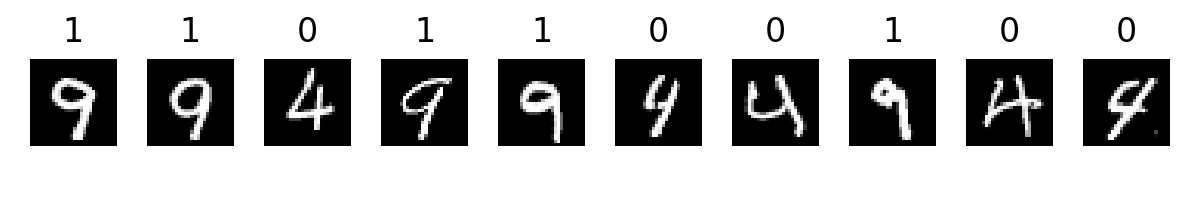

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(6, 1), tight_layout=True)
for i in range(10):
    image, label = train_dataset[np.random.randint(len(train_dataset))]
    ax[i].imshow(image.numpy()[0, :, :], cmap=plt.cm.Greys_r)
    ax[i].axis('off')
    ax[i].set_title(label)

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler

validationSize = 0.85
trainBatchSize = 128
validBatchSize = 128
testBatchSize = 256



idx = list(range(len(train_dataset)))
np.random.shuffle(idx)
split = int(validationSize*len(idx))

train_loader = DataLoader(train_dataset, batch_size=trainBatchSize, drop_last=False,
                          sampler=SubsetRandomSampler(idx[:split]))

valid_loader = DataLoader(train_dataset, batch_size=validBatchSize, drop_last=False,
                          sampler=SubsetRandomSampler(idx[split:]))

test_loader = DataLoader(test_dataset, batch_size=testBatchSize, drop_last=False,
                          shuffle=True)

In [5]:
COMPLETE_TEST_X = torch.tensor([])
COMPLETE_TEST_Y = torch.tensor([])
for X, y in test_loader:
    COMPLETE_TEST_X = torch.cat((COMPLETE_TEST_X, X), 0)
    COMPLETE_TEST_Y = torch.cat((COMPLETE_TEST_Y, y), dim=0)

<IPython.core.display.Javascript object>


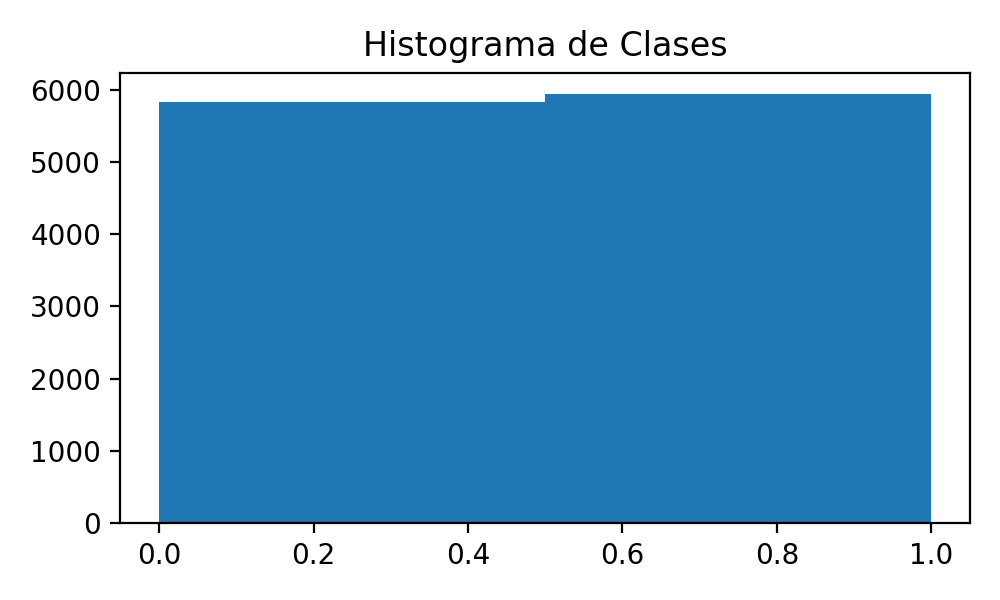

In [6]:
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.hist(train_dataset.dataset.targets[train_dataset.indices].numpy(), bins=2)
ax.set_title("Histograma de Clases");

# Deterministic Lenet5

In [97]:
from NeuralNetworks import Lenet5Deterministic
deterministicModel = Lenet5Deterministic()

In [98]:
deterministicLearningRate = 3e-4

loss = nn.BCELoss()
optimizer = torch.optim.Adam(deterministicModel.parameters(), lr=deterministicLearningRate)

def train_loop(dataloader, model, loss_fn, optimizer, n_samples):
    size = n_samples
    epochLoss = 0
    nSamples = 0
    for batch, (X, y) in enumerate((dataloader)):
        # Compute prediction and loss
        y = y.type(torch.float)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epochLoss += loss.item()
        nSamples += len(X)

    return epochLoss/nSamples
            

def valid_loop(dataloader, model, loss_fn, n_samples):
    size = n_samples
    test_loss, correct = 0, 0
    epochLoss = 0
    nSamples = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.type(torch.float)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            epochLoss += test_loss
            nSamples += len(X)

    test_loss /= size
    correct /= size
    print(f"         Validation Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}", end='\r')
    return epochLoss/nSamples
    
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    print(size)
    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.float)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

<IPython.core.display.Javascript object>


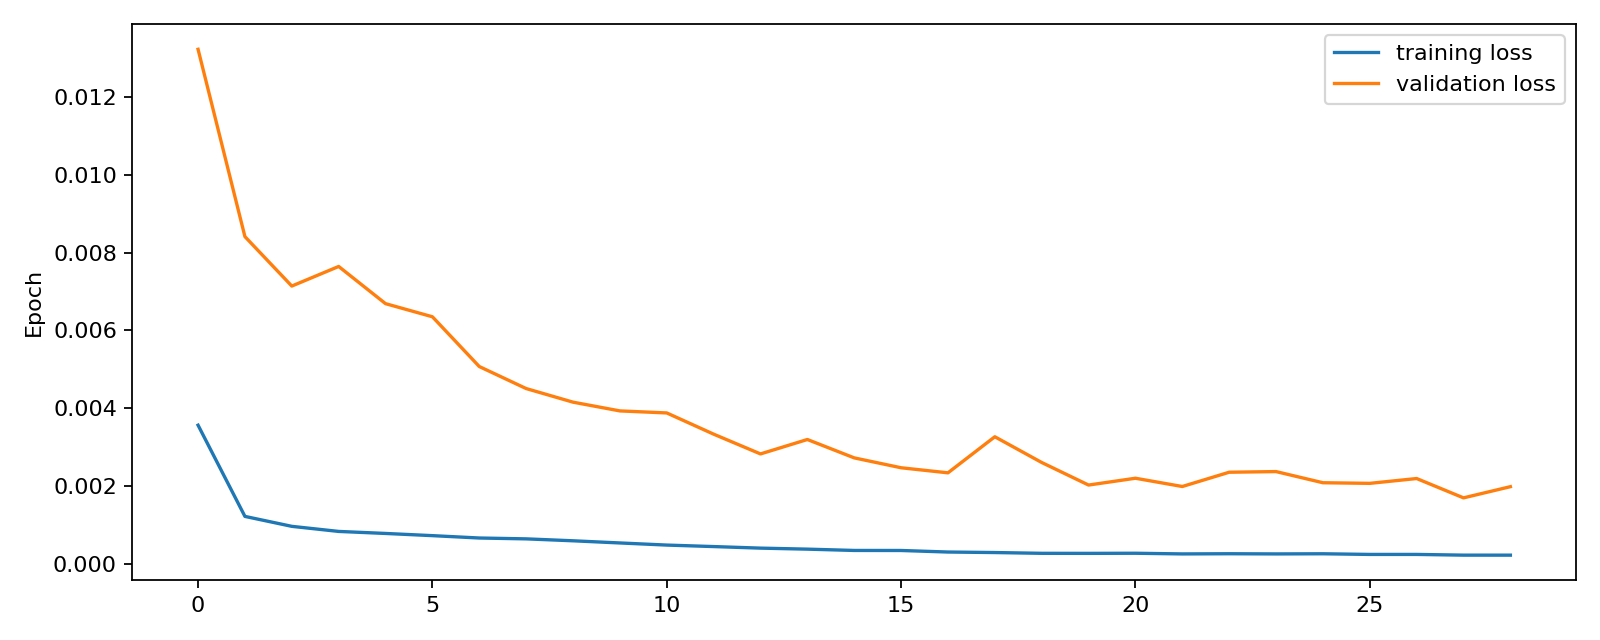

In [99]:
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, dpi=80)

def update_plot(k, trainingLosses, validLosses):
    ax.cla()
    ax.plot(range(k), trainingLosses[:k], label="training loss")
    ax.plot(range(k), validLosses[:k], label="validation loss")

    #ax.set_yscale('log')
    ax.set_ylabel('Loss')
    ax.set_ylabel('Epoch')
    ax.legend()
    fig.canvas.draw()

In [100]:
from IPython.display import display, clear_output

epochs = 30

trainingLosses = np.zeros(epochs)
validLosses = np.zeros(epochs)

for t in range(epochs):
    #clear_output(wait=True)
    print(f"Epoch {t+1} ", end='\r')
    trainingLosses[t] = train_loop(train_loader, deterministicModel, loss, optimizer, split)
    validLosses[t] = valid_loop(valid_loader, deterministicModel, loss, len(train_loader.dataset)-split)
    update_plot(t, trainingLosses, validLosses)
    

test_loop(test_loader, deterministicModel, loss)


print("Done!")

1991     Validation Error: Accuracy: 99.0%, Avg loss: 0.000290
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.000085 

Done!


# Bayesian Lenet5

In [126]:
def getCollapsedDecision(samples, delta):
    #return (samples.mean(dim=0))
    return (samples.mean(dim=0).numpy() > delta).astype(int)

In [146]:
from NeuralNetworks import Lenet5Bayesian
bayesianModel = Lenet5Bayesian(prior_scale=1., isFEBayesian=True, prior_scaleFE=3.).to('cuda')


<IPython.core.display.Javascript object>


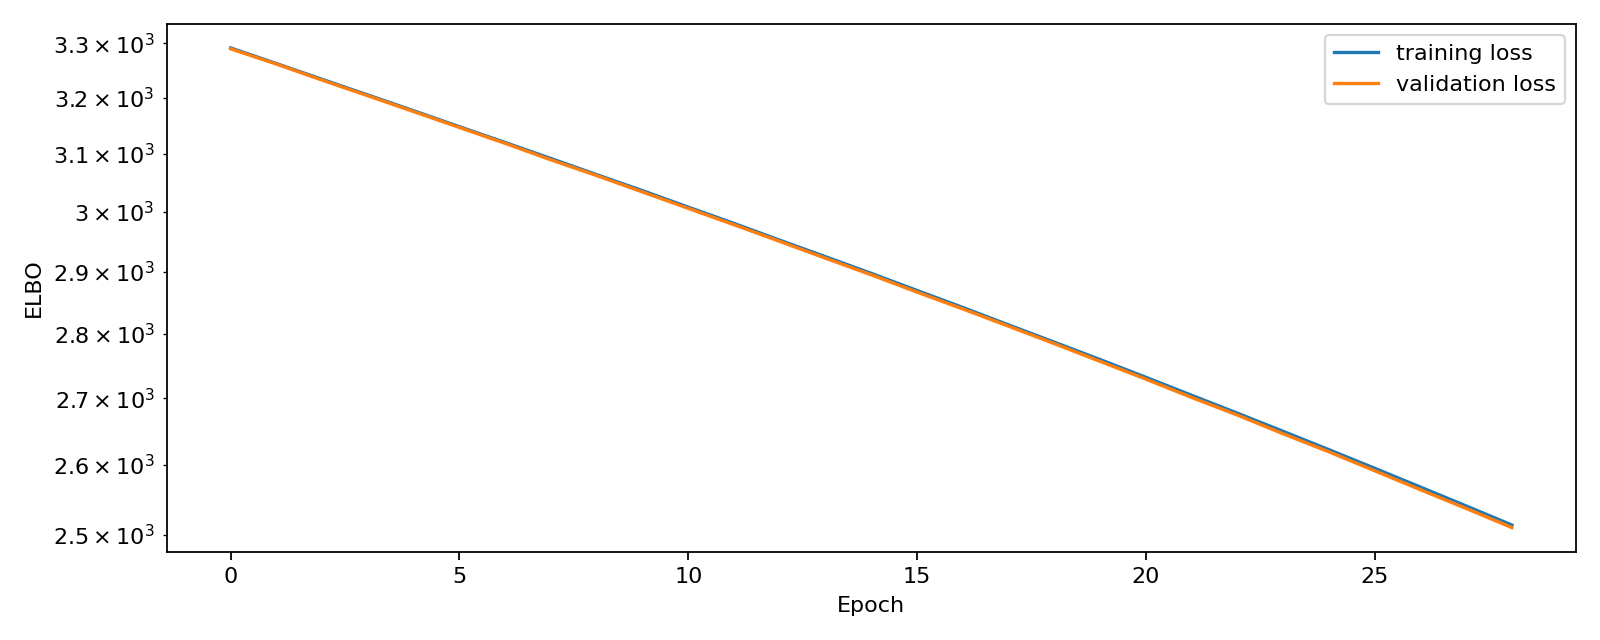

In [147]:
pyro.enable_validation(True)
fig, ax = plt.subplots(figsize=(10, 4), tight_layout=True, dpi=80)

def update_plot(k, trainingLosses, validLosses):
    ax.cla()
    ax.plot(range(k), trainingLosses[:k], label="training loss")
    ax.plot(range(k), validLosses[:k], label="validation loss")

    ax.set_yscale('log')
    ax.set_ylabel('ELBO')
    ax.set_xlabel('Epoch')
    ax.legend()
    fig.canvas.draw()

In [148]:
# Turn this on for additional debugging
pyro.enable_validation(False) 
pyro.clear_param_store() 
epochs = 30

# Create a guide
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(bayesianModel, init_scale=1e-4)
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=100)
# Create SVI object
svi = pyro.infer.SVI(bayesianModel, guide, 
                     optim=pyro.optim.ClippedAdam({'lr':1e-3, 'clip_norm':1.0}), # Optimizer
                     loss=pyro.infer.TraceMeanField_ELBO()) # Loss function 

epoch_loss = np.zeros(shape=(epochs,))
validLoss = np.zeros(shape=(epochs,))


for k in tqdm(range(len(epoch_loss))):
    acumloss = 0
    n = 0
    for X, y in train_loader:
        acumloss += svi.step(x=X, y=y.type(torch.float)) # Actual training step
        n+=(X.shape[0])
    epoch_loss[k] = acumloss/n

    #update_plot(k, epoch_loss, validLoss)   
    res = 0
    total = 0
    acumloss = 0
    for X, y in valid_loader:
        acumloss += svi.evaluate_loss(X, y.type(torch.float))
        ans = getCollapsedDecision(predictive(X)['obs'].detach(), 0.5)
        correct = accuracy_score(y, ans, normalize=False)
        res += correct
        total += X.shape[0]
    validLoss[k] = acumloss/total
    #print(epoch_loss, validLoss)
    update_plot(k, epoch_loss, validLoss)
    print("Validation Score:", res/total*100, end='\r')
 
            

  0%|          | 0/30 [00:00<?, ?it/s]

Cuando el modelo se entrena demasiado (ya sea durante muchas epocas o con un learning rate alto) el score baja a 0.5 por algun motivo. Que sucede cuando las redes bayesianas se sobreajustan?

In [149]:
predictive = pyro.infer.Predictive(bayesianModel, guide=guide, num_samples=500)

aciertos = 0
total = 0

with torch.no_grad():
    for X, y in tqdm(test_loader):
        out = predictive(X)['obs'].detach()
        ans = getCollapsedDecision(out, 0.5)
        aciertos += accuracy_score(y, ans, normalize=False)
        total += X.shape[0]

        
        print("Test score:", aciertos/total*100, end='\r')


  0%|          | 0/8 [00:00<?, ?it/s]

Los accuracy scores obtenidos por las redes en el set de pruebas son:
- Deterministica: 99.4%
- Bayesiana: ~99.0 %

Sin embargo, el accuracy puede variar unos puntos por un factor de aleatoridad. Ambos modelos son capaces de resolver perfectamente el problema, sin embargo, la principal diferencia esta en la informacion extra que entrega el modelo bayesiano. (ver ultima seccion)

# Evaluating the bayesian classifier

In [150]:
bayesianErrorsIdx = []
bayesianSamples = []

deterministicErrorsIdx = []
deterministicOutput = []

trueLabelsIdx = []

with torch.no_grad():
    out = predictive(COMPLETE_TEST_X)['obs'].detach()
    ans = getCollapsedDecision(out, 0.5)
    hitormiss = (ans == COMPLETE_TEST_Y.type(torch.long).numpy())
    bayesianErrorsIdx = np.where(hitormiss == False)[0]
    bayesianSamples = out.numpy().T[bayesianErrorsIdx]
        
with torch.no_grad():
    out = deterministicModel(COMPLETE_TEST_X)
    ans = (out.numpy() > 0.5).astype(int)
    #print(ans, COMPLETE_TEST_Y.type(torch.long).numpy())
    hitormiss = (ans == COMPLETE_TEST_Y.type(torch.long).numpy())
    deterministicErrorsIdx = np.where(hitormiss == False)[0]
    deterministicOutput = out[deterministicErrorsIdx]
    trueLabels = COMPLETE_TEST_Y[deterministicErrorsIdx]

# Evaluating the bayesian classifier

<IPython.core.display.Javascript object>


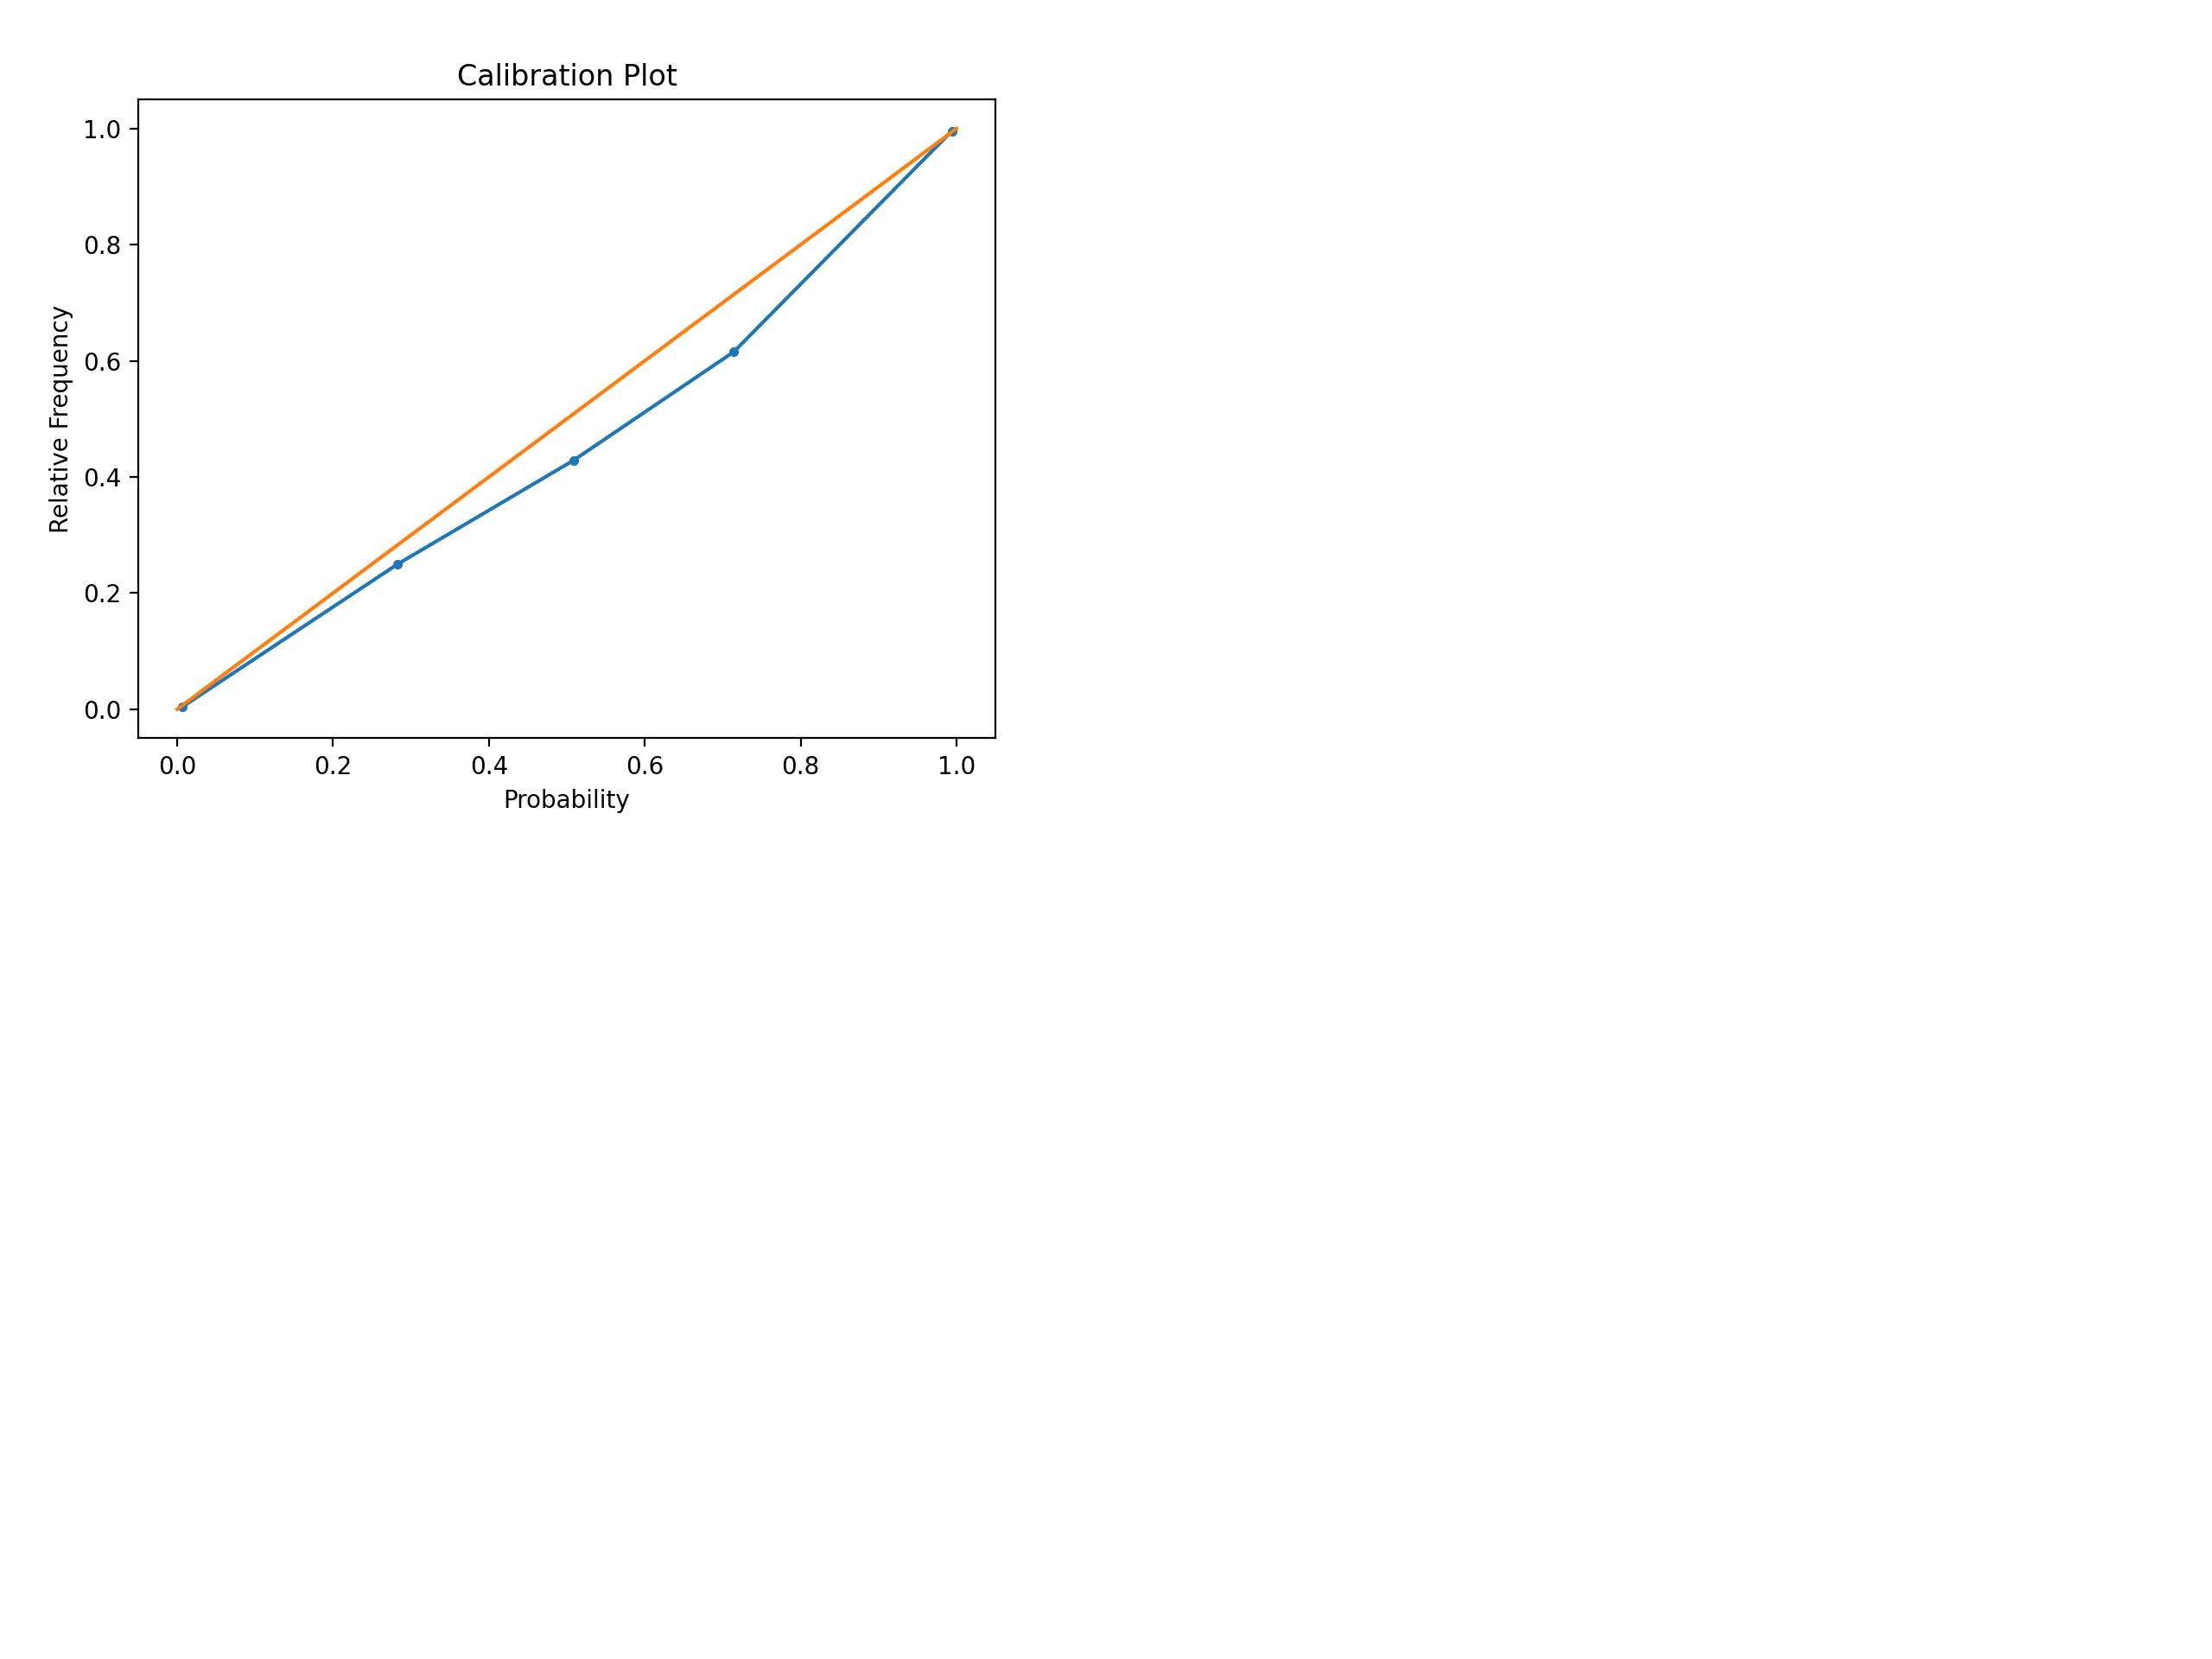

In [152]:
from sklearn.calibration import calibration_curve
samplesAvg = 0
with torch.no_grad():
    samplesAvg = predictive(COMPLETE_TEST_X)['obs'].detach().type(torch.float).mean(dim=0)
prob_true, prob_pred = calibration_curve(COMPLETE_TEST_Y, samplesAvg, n_bins=5)
fig, ax = plt.subplots()
ax.plot(prob_pred, prob_true, label="Clase", marker='.');
ax.set_xlabel("Probability")
ax.set_ylabel("Relative Frequency")
ax.set_title("Calibration Plot")
ax.plot(np.linspace(0, 1, 2),np.linspace(0, 1, 2), label='y = x');

De acuerdo al Uncertainty Calibration plot de arriba, el modelo bayesiano entrenado esta cercano a lo que se conoce como "Calibracion perfecta" pues la linea azul, que representa la confianza del modelo en las predicciones, esta cerca de la linea naranja, que reprenta una calibracion perfecta.

Entrando mas en detalle, el modelo parece tener una pequena inclinacion a estar "overconfident" acerca de las predicciones con probabilidad entre $0.5$ y $0.8$. Esto significa que para predicciones en las que cae en ese intervalo se estima una probabilidad mayor de la que deberia.

<IPython.core.display.Javascript object>


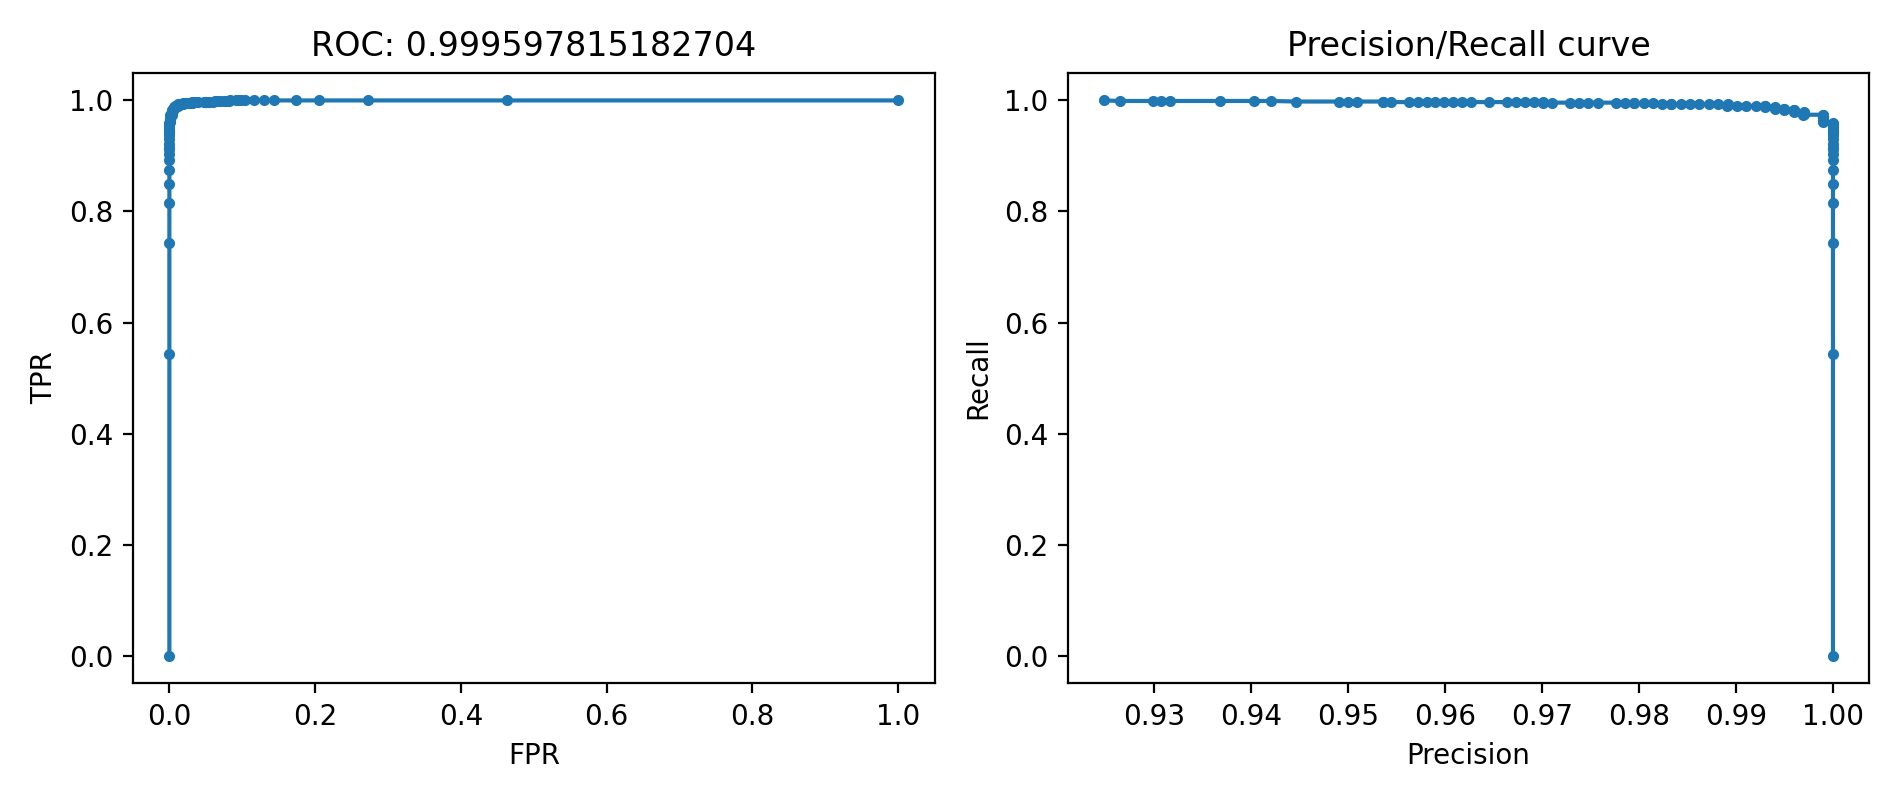

In [153]:
ns_fpr, ns_tpr, _ = roc_curve(COMPLETE_TEST_Y, samplesAvg)
pre, rec, _ = precision_recall_curve(COMPLETE_TEST_Y, samplesAvg)
roc = roc_auc_score(COMPLETE_TEST_Y, samplesAvg)

fig, ax = plt.subplots(1,2, figsize=(9.5, 4), tight_layout=True)
ax[0].plot(ns_fpr, ns_tpr, label="Clase", marker='.');
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].set_title("ROC: {}".format(roc))

ax[1].plot(pre, rec, label="Clase", marker='.');
ax[1].set_xlabel("Precision")
ax[1].set_ylabel("Recall")
ax[1].set_title("Precision/Recall curve");


La curva FPR/TPR muestra resultados bastantes positivos. Con un ROC practicamente en 1. Esto quiere decir que al escoger el umbral correcto (0.5 en nuestro caso), practicamente no existe tradeoff entre clasificar correctamente las observaciones a coste de clasificar incorrectamente otras.
El grafico de la derecha muestra la curva Precision/Recall con resultados, nuevamente, bastante positivos. Con ambos valores cercanos a 1 con un umbral de 0.5.

In [154]:
print(classification_report(COMPLETE_TEST_Y, (samplesAvg.numpy() > 0.5).astype(int)))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       982
         1.0       0.99      0.99      0.99      1009

    accuracy                           0.99      1991
   macro avg       0.99      0.99      0.99      1991
weighted avg       0.99      0.99      0.99      1991



El metodo `classification_report` de Scikit Learn nos entrega informacion mas concreta sobre las metricas de evaluacion. Aqui podemos ver que efectivamente con un umbral de $0.5$ el precision y recall para ambas clases es muy cercano a $1$. Ademas de un accuracy del $99\%$.

En conclusion, el clasificador binario bayesiano alcanzo un alto nivel de accuracy, ademas que estar casi perfectamente calibrado en cuando a su incerteza. Esto nos ayuda a tener la posibilidad de estudiar aquellos casos en los que el clasificador no este completamente seguro de una clase en particular.

# Arruinando el clasificador bayesiano: Analisis de sensibilidad

La mejor version del clasificador bayesiano se entreno con los siguientes parametros:
- Escala inicial del prior normal: $1$ para las capas lineales y $3$ para las convolucionales.
- Escala del posterior aproximado: $1e-3$.
Ambas distribuciones normales centradas en $0$.

Sin embargo para realizar el analisis de sensibilidad se utilizo como referencia una escala de prior normal de $1$ para todas las capas y escala del posterior aproximado normal de $1e-3$. Ademas todas las pruebas utilizaron una tasa de aprendizaje de $1e-3$ y un maximo de $20$ epocas de entrenamiento. \
La configuracion de referencia obtuvo un accuracy de $99\%$. 

![d](imgs/loss-1.0-1e3.jpg)

Con calibracion:

![d](imgs/calibration-1.0-1e3.jpg)

En este caso se obtiene un modelo con buenas predicciones y sobre confiado de aquellas predicciones con baja probabilidad.

Primero se modifico la escala incial del prior normal mientras se matuvo constante el posterior aproximado.
Al utilizar un valor de $10$, en las $20$ epocas alcanza un accuracy de $75\%$ con un grafico de calibracion que muestra sobre confianza y baja confianza mas agresivos al caso anterior:

![d](imgs/calibration-10.0-1e3.jpg)

Ademas, se intento aumentar el numero de epocas a $50$, con lo cual logro llegar a un accuracy de $90\%$. Es probable que al entrenar mas, se podria aumentar el accuracy, sin embargo, la calibracion no mejora. Lo que indica que no es optimo.

Al aumentar la escala del prior a $100$ el modelo se queda en una especie de minimo local con un $50\%$ de accuracy, independiente del numero epoca en la que se encuentre. A pesar de que el grafico de la evolucion del ELBO muestra una baja constante, similar a caso de referencia, la calidad del modelo no mejora. Su grafico de calibracion muestra a la recta $y= 0.5$.

Por otro lado, al disminuir el la escala del prior a $0.5$ se alcanza un accuracy de $97\%$, mas bajo que el modelo de referencia. El resto se mantiene similar al modelo con una escala de $10$ (grafico de calibracion de arriba). Sin embargo, al disminuir la escala a $0.1$ el modelo 'diverge' nuevamente, manteniendo un $50\%$ de accuracy independiente del numero de epocas.

Al aumentar la escala del posterior aproximado a $0.01$ se obtiene un $98\%$ de accuracy, con buenos resultados pero no optimos, pues la curva de calibracion muestra predicciones sobre y bajo confiadas. Ver imagen de abajo.

![d](imgs/calibration-1.0-1e2.jpg)

Al utilizar una escala de $0.1$, nuevamente se alcanza un accuracy de $98\%$. Muy similar al caso anterior, sin embargo, la calibracion se ve aun mas agresiva.

![d](imgs/calibration-1.0-1e1.jpg)

Al aumentar a $1.0$ el modelo se atasca en un $50\%$ de accuracy. Su grafica de loss tambien es mas ruidosa.

![d](imgs/loss-1.0-1.0.jpg)


Cuando se entrena con escalas menores al modelo de referencia como $1e-4$, $1e-5$ o $1e-6$, el modelo sigue alcanzando buenos accuracys, sobre $95\%$, pero descalibrados.
A continuacion se presentan 2 graficos de calibracion cuando la escala del prior del posterior es $1e-5$ y $1e-10$, respectivamente:

![d](imgs/calibration-1.0-1e4.jpg)

![d](imgs/calibration-1.0-1e10.jpg)

Es curioso que cuando el programa se deja entrenar durante muchas epocas, o cuando la tasa de aprendizaje es muy grande el ELBO parecia llegar a un minimo, y el accuracy del modelo queda estancado en $50\%$. En los casos descritos anteriormente cuando el accuracy se estancaba al $50\%$, la loss no alcanzaba a quedar en este minimo, pero habia una tendencia a llegar. En el siguiente grafico se puede apreciar este caso:

![d](imgs/loss-overfit.jpg)


##### En resumen...

Se realizo un analisis de sensibilidad de 2 parametros: la escala del prior y la escala del posterior aproximado (ambos son distribuciones normales). Modificar la escala del prior, parece afectar directamente en la velocidad de convergencia del modelo (similar a la tasa de aprendizaje) y en la confianza que tiene el modelo sobre sus predicciones. Cuando se aumenta, se necesita de mayor tiempo de entrenamiento para alcanzar buenos resultados. El modelo parece ser mucho mas sensible a disminuir la escala desde $1.0$ que aumentarla.
Variar la escala del posterior aproximado no afecto en gran medida el rendimiento del modelo en cuanto a accuracy, sin embargo, los graficos de calibracion muestran que se obtienen modelos cada vez menos calibrados a medida que se disminuye la escala (este efecto tambien ocurre al aumentar la escala pero es menos agresivo). Esto puede ser ya que al disminuir la escala, la salida de una normal deja de tener variabilidad y las predicciones se vuelven iguales.

# Plotting error cases

## Deterministic first

Cantidad de clasificaciones erradas: 13


<IPython.core.display.Javascript object>


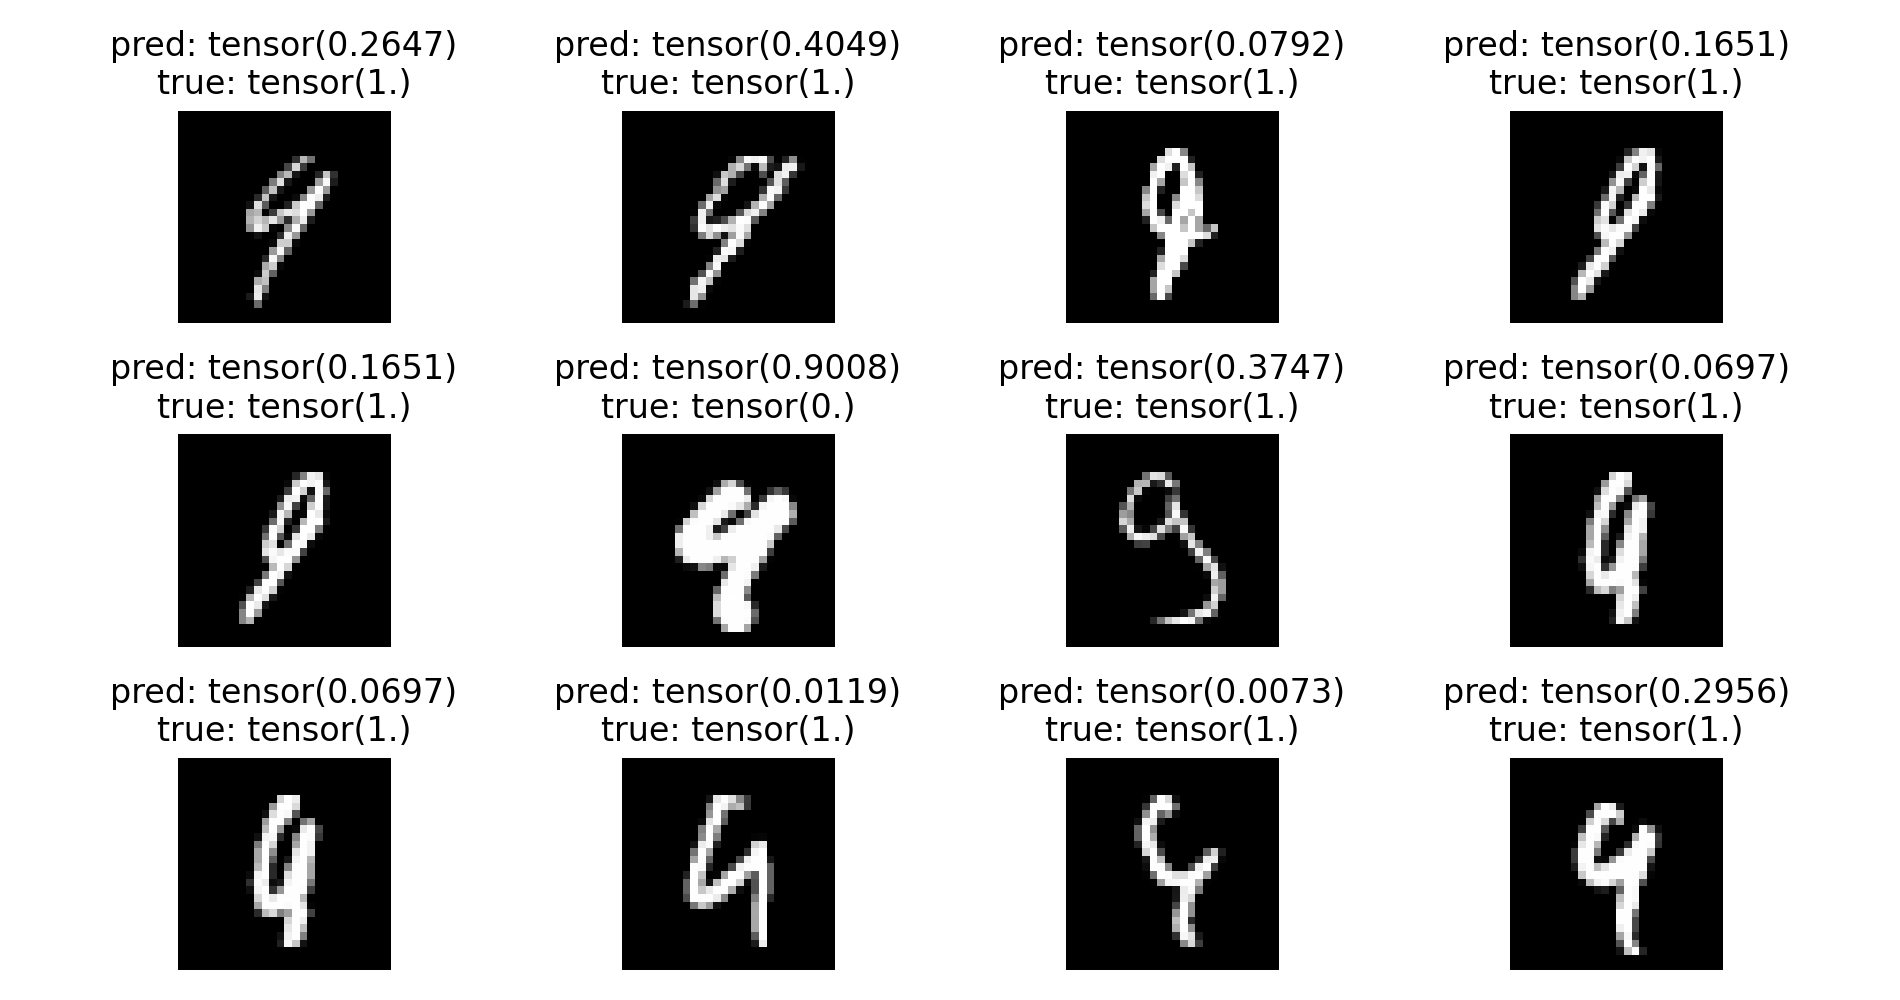

In [155]:
nerrors = len(deterministicErrorsIdx)
print("Cantidad de clasificaciones erradas:", nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(9.5, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = COMPLETE_TEST_X[deterministicErrorsIdx[i*rows+j]].squeeze(0).squeeze(0).unsqueeze(2)
        conf = deterministicOutput[i*rows+j]
        if nerrors>1:
            ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
            ax[i,j].axis('off')        
            ax[i,j].set_title("pred: "+str(conf) + "\ntrue: "+str(trueLabels[i*rows+j]))
        else:
            ax.imshow(image.numpy(), cmap=plt.cm.Greys_r)
            ax.axis('off')        
            ax.set_title("pred: "+str(conf) + "\ntrue: "+str(trueLabels[i*rows+j]))

## Now Bayesian

Cantidad de clasificaciones erradas: 20


<IPython.core.display.Javascript object>


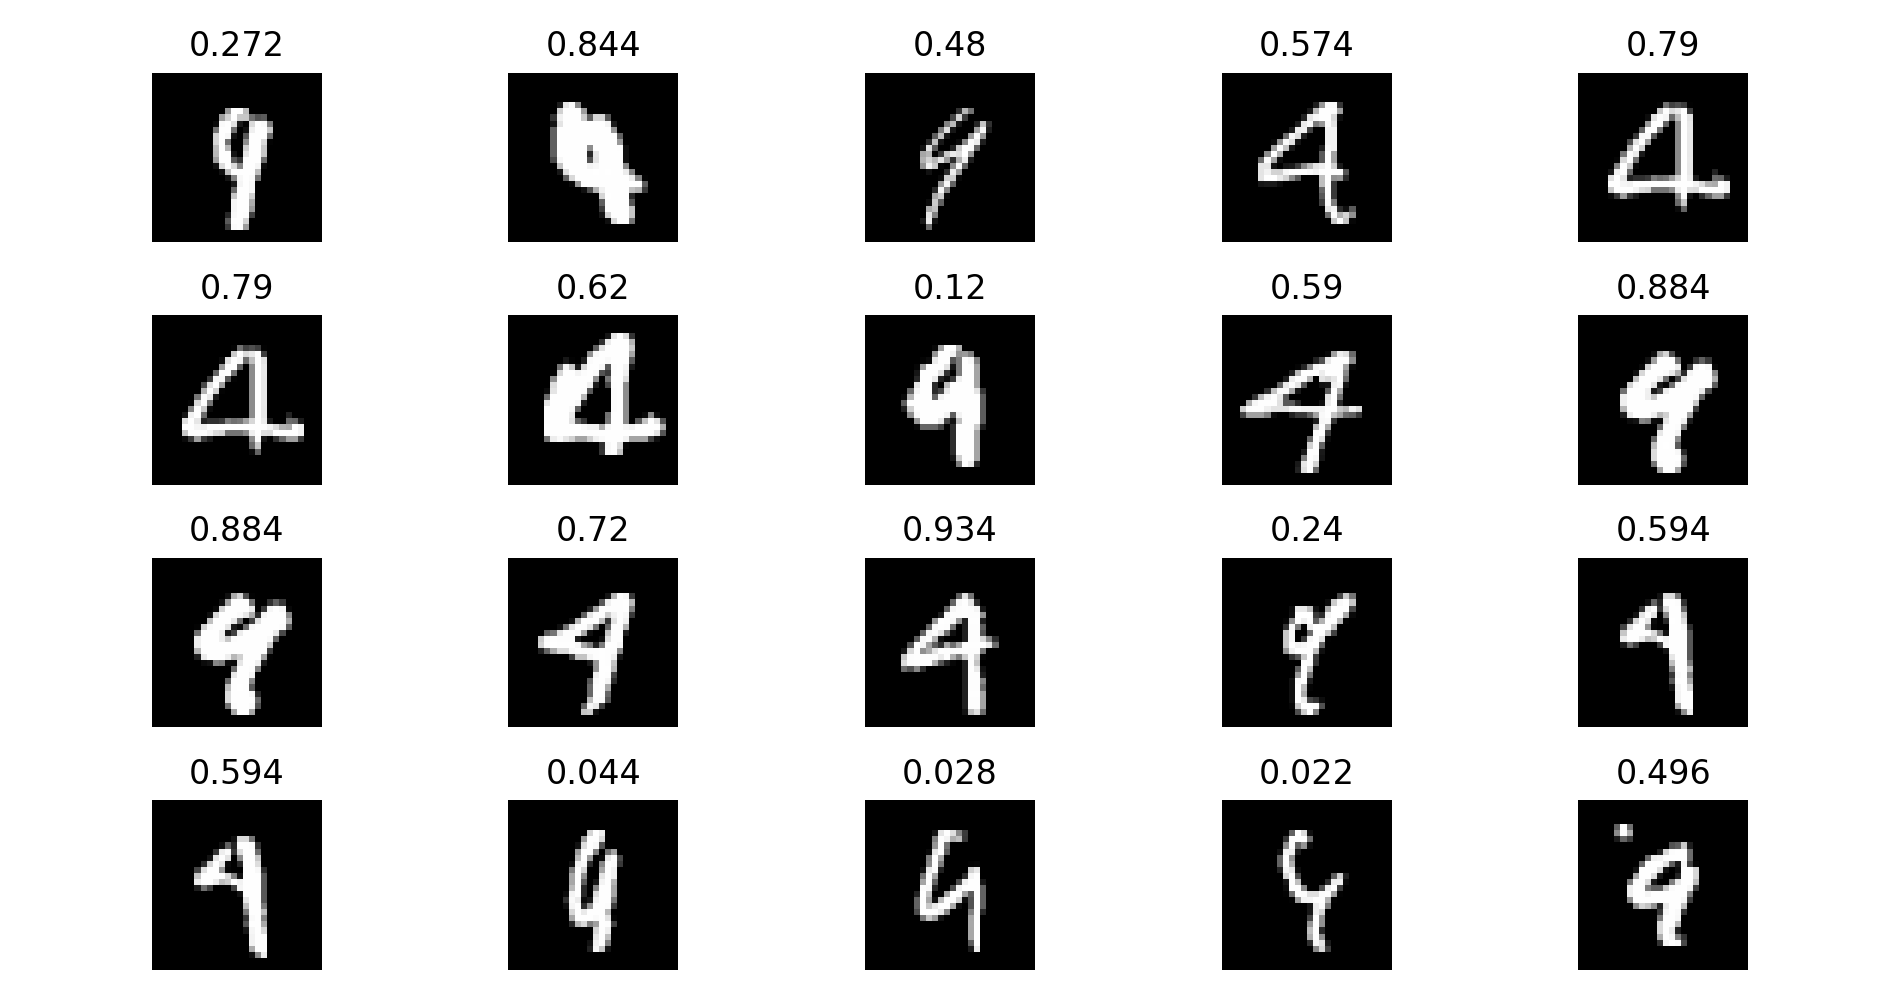

In [156]:
nerrors = len(bayesianErrorsIdx)
print("Cantidad de clasificaciones erradas:", nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(9.5, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = COMPLETE_TEST_X[bayesianErrorsIdx[i*rows+j]].squeeze(0).squeeze(0).unsqueeze(2)
        conf = np.average(bayesianSamples[i*rows+j])
        ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
        ax[i,j].axis('off')        
        ax[i,j].set_title(conf)

# Casos en los que ambos se equivocaron

[143, 725, 1033, 1034, 1231, 1780, 1898]
Cantidad de clasificaciones erradas en comun: 7


<IPython.core.display.Javascript object>


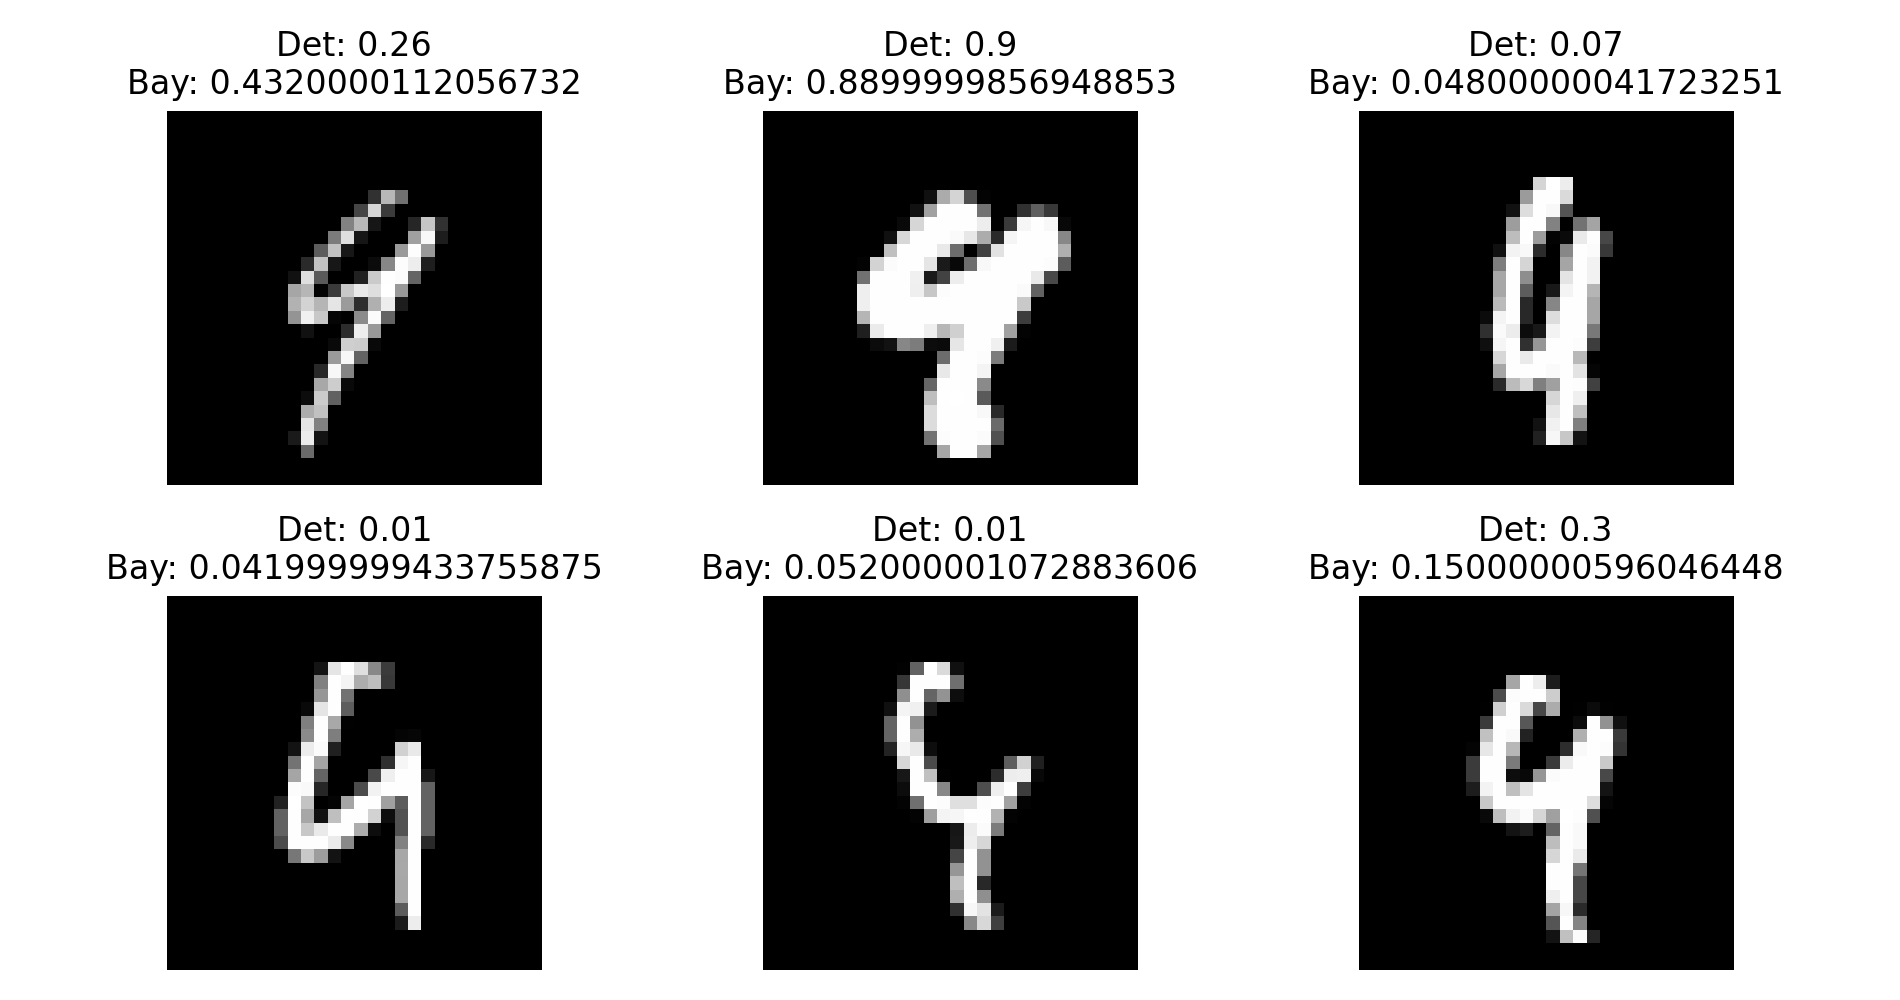

In [157]:
from collections import Counter
errIdx = list((Counter(bayesianErrorsIdx) & Counter(deterministicErrorsIdx)).elements())
print(errIdx)
nerrors = len(errIdx)
print("Cantidad de clasificaciones erradas en comun:", nerrors)
rows = int(np.floor(np.sqrt(nerrors)))
cols = nerrors//rows
fig, ax = plt.subplots(rows, cols, figsize=(9.5, 5), tight_layout=True)
for i in range(rows):
    for j in range(cols):
        image = COMPLETE_TEST_X[errIdx[i*cols+j]].squeeze(0).squeeze(0).unsqueeze(2)
        probBay = predictive(COMPLETE_TEST_X[errIdx[i*cols+j]].unsqueeze(0))['obs'].detach().mean().item()
        probDet = deterministicModel(COMPLETE_TEST_X[errIdx[i*cols+j]].unsqueeze(0))
        ax[i,j].imshow(image.numpy(), cmap=plt.cm.Greys_r)
        ax[i,j].axis('off')        
        ax[i,j].set_title("Det: " + str(np.round(probDet.item(), 2)) + "\nBay: " + str(probBay))

Ambos modelos predicen bastante bien y se equivocan con casos en los que hasta para un humano seria complicado. Para alcanzar un alto accuracy con el modelo determinista, solo basto con entrenar con los parametros por defecto. No fue necesario tunear finamente parametros. Por otra parte, para alcanzar un rendimiento similar con el modelo bayesiano fue necesario realizar multiples entrenamientos con distintos hiperparametros.
En cuanto a las predicciones, en la figura de arriba se puede ver los casos en los que ambos modelos realizaron una clasificacion errada. La diferencia entre la salida de cada red no parece ser mucha, sin embargo, el modelo bayesiano suele dar predicciones menos marcadas.